In [5]:
from finders.data_finders import find_csv_dir_files_china
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import traceback
from collections import Counter
import logging

warnings.filterwarnings("ignore")

# Настройка логирования
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

# Настройка стиля графиков
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

In [6]:
# Функция для извлечения основного AHA кода
def extract_primary_aha_code(code):
    if pd.isna(code):
        return np.nan

    code_str = str(code)

    # Разделяем по различным разделителям
    for separator in ["+", ";", "/", ",", "|"]:
        if separator in code_str:
            parts = code_str.split(separator)
            # Берем первую часть и пытаемся извлечь число
            first_part = parts[0].strip()
            # Ищем цифры в начале строки
            match = re.match(r"(\d+)", first_part)
            if match:
                return int(match.group(1))
            return np.nan

    # Если нет разделителей, пытаемся преобразовать напрямую
    try:
        return int(float(code_str))
    except:
        return np.nan


# Функция для анализа и визуализации ОСНОВНЫХ AHA кодов
def visualize_primary_aha_codes(df_analysis):
    """
    Создает полную визуализацию всех основных AHA кодов
    """
    print("\n" + "=" * 70)
    print("АНАЛИЗ ОСНОВНЫХ AHA КОДОВ (ПЕРВЫЙ КОД В ЗАПИСИ)")
    print("=" * 70)

    # Получаем все уникальные коды с их частотами и сортируем по убыванию частоты
    aha_counts = df_analysis["Primary_AHA"].value_counts().sort_values(ascending=False)

    # Убираем NaN значения
    aha_counts = aha_counts.dropna()

    total_unique_codes = len(aha_counts)
    total_records = len(df_analysis)

    print(f"Всего уникальных основных AHA кодов: {total_unique_codes}")
    print(f"Общее количество записей: {total_records}")

    # Преобразуем в словарь для дальнейшего использования
    primary_counts_dict = aha_counts.to_dict()

    # Создаем подробный отчет по всем кодам
    print(
        f"\nПОЛНЫЙ СПИСОК ОСНОВНЫХ AHA КОДОВ ({total_unique_codes} уникальных кодов):"
    )
    print("=" * 80)

    cumulative_percent = 0
    all_codes_data = []

    for i, (code, count) in enumerate(aha_counts.items(), 1):
        percentage = count / total_records * 100
        cumulative_percent += percentage
        all_codes_data.append(
            {
                "Rank": i,
                "AHA_Code": code,
                "Count": count,
                "Percentage": percentage,
                "Cumulative_Percentage": cumulative_percent,
            }
        )

        # Выводим только топ-20 для наглядности в консоли
        if i <= 20:
            print(
                f"{i:4d}. AHA {code:4d}: {count:6d} записей ({percentage:6.2f}%) | "
                f"Кумулятивно: {cumulative_percent:6.2f}%"
            )

    print("\nОБЩАЯ СТАТИСТИКА:")
    print(
        f"• Топ-15 кодов покрывают: {aha_counts.head(15).sum() / total_records * 100:.2f}% всех записей"
    )
    print(
        f"• Топ-60 кодов покрывают: {aha_counts.head(60).sum() / total_records * 100:.2f}% всех записей"
    )
    print(f"• Медианная частота кода: {aha_counts.median():.1f} записей")
    print(f"• Средняя частота кода: {aha_counts.mean():.1f} записей")

    # Создаем комплексные графики
    fig = plt.figure(figsize=(18, 12))

    # 1. Топ-15 основных кодов
    ax1 = plt.subplot(2, 2, 1)
    top_15 = aha_counts.head(15)

    bars = ax1.bar(
        range(len(top_15)),
        top_15.values,
        color=plt.cm.Set3(np.arange(len(top_15))),
        edgecolor="black",
    )

    ax1.set_title(
        f"Топ-15 основных AHA кодов\n({top_15.sum() / total_records * 100:.1f}% покрытия данных)",
        fontsize=14,
        fontweight="bold",
    )
    ax1.set_xlabel("AHA Код", fontsize=12)
    ax1.set_ylabel("Количество записей", fontsize=12)
    ax1.set_xticks(range(len(top_15)))
    ax1.set_xticklabels(top_15.index, rotation=45, fontsize=10)
    ax1.grid(True, alpha=0.3, axis="y")

    # Добавляем значения на столбцы
    for bar, count in zip(bars, top_15.values):
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.1,
            f"{int(count)}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    # 2. Распределение частот всех кодов (лог шкала)
    ax2 = plt.subplot(2, 2, 2)

    # Создаем гистограмму с логарифмической шкалой
    counts = aha_counts.values
    ax2.hist(counts, bins=50, edgecolor="black", alpha=0.7, color="skyblue", log=True)
    ax2.set_title(
        "Распределение частот всех основных AHA кодов\n(лог шкала)",
        fontsize=14,
        fontweight="bold",
    )
    ax2.set_xlabel("Частота кода", fontsize=12)
    ax2.set_ylabel("Количество кодов (лог шкала)", fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Добавляем статистические линии
    ax2.axvline(
        aha_counts.mean(),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Среднее: {aha_counts.mean():.1f}",
    )
    ax2.axvline(
        aha_counts.median(),
        color="green",
        linestyle="--",
        linewidth=2,
        label=f"Медиана: {aha_counts.median():.1f}",
    )
    ax2.legend()

    # 3. Кумулятивное распределение
    ax3 = plt.subplot(2, 2, 3)

    cumulative = aha_counts.cumsum() / total_records * 100

    ax3.plot(
        range(1, len(cumulative) + 1), cumulative.values, linewidth=2, color="darkblue"
    )
    ax3.fill_between(
        range(1, len(cumulative) + 1), cumulative.values, alpha=0.3, color="lightblue"
    )
    ax3.set_title(
        "Кумулятивное распределение основных AHA кодов", fontsize=14, fontweight="bold"
    )
    ax3.set_xlabel("Количество самых частых кодов", fontsize=12)
    ax3.set_ylabel("Процент покрытия данных (%)", fontsize=12)
    ax3.grid(True, alpha=0.3)

    # Добавляем основные пороговые линии
    thresholds = [50, 80, 90, 95, 99]
    colors = ["green", "orange", "red", "purple", "brown"]

    for threshold, color in zip(thresholds, colors):
        ax3.axhline(threshold, color=color, linestyle="--", alpha=0.5, linewidth=1)
        if any(cumulative >= threshold):
            idx = np.where(cumulative.values >= threshold)[0][0] + 1
            ax3.text(
                idx,
                threshold,
                f" {idx} кодов",
                ha="left",
                va="center",
                fontsize=9,
                color=color,
                fontweight="bold",
            )

    ax3.set_xlim(0, min(200, len(cumulative)))

    # 4. Количественное распределение кодов по частотам
    ax4 = plt.subplot(2, 2, 4)

    # Группируем коды по частоте
    freq_bins = [0, 1, 5, 10, 50, 100, 500, 1000, float("inf")]
    freq_labels = [
        "1",
        "2-5",
        "6-10",
        "11-50",
        "51-100",
        "101-500",
        "501-1000",
        ">1000",
    ]

    freq_dist = (
        pd.cut(aha_counts, bins=freq_bins, labels=freq_labels)
        .value_counts()
        .sort_index()
    )

    bars_freq = ax4.bar(
        range(len(freq_dist)),
        freq_dist.values,
        color=plt.cm.Pastel1(np.arange(len(freq_dist))),
        edgecolor="black",
    )

    ax4.set_title(
        "Распределение кодов по частоте встречаемости", fontsize=14, fontweight="bold"
    )
    ax4.set_xlabel("Диапазон частот", fontsize=12)
    ax4.set_ylabel("Количество кодов", fontsize=12)
    ax4.set_xticks(range(len(freq_dist)))
    ax4.set_xticklabels(freq_dist.index, rotation=45, fontsize=10)
    ax4.grid(True, alpha=0.3, axis="y")

    # Добавляем значения на столбцы
    for bar, count in zip(bars_freq, freq_dist.values):
        height = bar.get_height()
        percentage = count / total_unique_codes * 100
        ax4.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.1,
            f"{count} ({percentage:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    plt.tight_layout()
    plt.show()

    # Создаем DataFrame с полными данными
    all_codes_df = pd.DataFrame(all_codes_data)

    return primary_counts_dict, all_codes_df


# Функция для анализа кодов после точки с запятой (;)
def analyze_semicolon_codes(df_analysis):
    """
    Анализирует все коды, которые идут после точки с запятой в AHA_Code
    """
    print("\n" + "=" * 70)
    print("АНАЛИЗ КОДОВ ПОСЛЕ ТОЧКИ С ЗАПЯТОЙ (;)")
    print("=" * 70)

    # Собираем все коды после точки с запятой
    semicolon_codes = []
    records_with_semicolon = 0

    for code in df_analysis["AHA_Code"].dropna():
        code_str = str(code)
        if ";" in code_str:
            records_with_semicolon += 1
            # Разделяем по точке с запятой
            parts = code_str.split(";")
            # Берем все части кроме первой (первая - основной код)
            for part in parts[1:]:
                part = part.strip()
                if part:
                    # Ищем числа в части
                    numbers = re.findall(r"\d+", part)
                    for num in numbers:
                        try:
                            semicolon_codes.append(int(num))
                        except:
                            continue

    if not semicolon_codes:
        print("Нет кодов после точки с запятой в данных")
        return None, None

    # Считаем частоты
    semicolon_counts = Counter(semicolon_codes)

    # Преобразуем в DataFrame и сортируем
    semicolon_df = pd.DataFrame.from_dict(
        semicolon_counts, orient="index", columns=["Count"]
    ).sort_values("Count", ascending=False)
    semicolon_df.index.name = "AHA_Code"
    semicolon_df = semicolon_df.reset_index()

    total_semicolon_entries = len(semicolon_codes)
    unique_semicolon_codes = len(semicolon_counts)
    total_records = len(df_analysis)

    print(
        f"Записей с точкой с запятой: {records_with_semicolon} ({records_with_semicolon / total_records * 100:.1f}% всех записей)"
    )
    print(f"Всего кодов после точки с запятой: {total_semicolon_entries}")
    print(f"Уникальных кодов после точки с запятой: {unique_semicolon_codes}")
    print(
        f"Среднее кодов на запись с ';': {total_semicolon_entries / records_with_semicolon:.2f}"
    )

    # Создаем график
    fig = plt.figure(figsize=(16, 10))

    # 1. Топ-15 кодов после точки с запятой
    ax1 = plt.subplot(2, 2, 1)
    top_semicolon = semicolon_df.head(15)

    bars1 = ax1.bar(
        range(len(top_semicolon)),
        top_semicolon["Count"].values,
        color=plt.cm.Set2(np.arange(len(top_semicolon))),
        edgecolor="black",
    )

    ax1.set_title(
        f'Топ-15 AHA кодов после ";"\n({unique_semicolon_codes} уникальных кодов)',
        fontsize=14,
        fontweight="bold",
    )
    ax1.set_xlabel("AHA Код", fontsize=12)
    ax1.set_ylabel("Количество включений", fontsize=12)
    ax1.set_xticks(range(len(top_semicolon)))
    ax1.set_xticklabels(top_semicolon["AHA_Code"], rotation=45)
    ax1.grid(True, alpha=0.3, axis="y")

    # Добавляем значения на столбцы
    for bar, count in zip(bars1, top_semicolon["Count"].values):
        height = bar.get_height()
        percentage = count / total_semicolon_entries * 100
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.1,
            f"{int(count)}\n({percentage:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=8,
        )

    # 2. Гистограмма распределения частот
    ax2 = plt.subplot(2, 2, 2)
    ax2.hist(
        semicolon_df["Count"].values,
        bins=30,
        edgecolor="black",
        alpha=0.7,
        color="lightblue",
    )
    ax2.set_title(
        'Распределение частот кодов после ";"', fontsize=14, fontweight="bold"
    )
    ax2.set_xlabel("Частота включения кода", fontsize=12)
    ax2.set_ylabel("Количество кодов", fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.axvline(
        semicolon_df["Count"].mean(),
        color="red",
        linestyle="--",
        label=f"Среднее: {semicolon_df['Count'].mean():.1f}",
    )
    ax2.legend()

    # 3. Кумулятивное распределение
    ax3 = plt.subplot(2, 2, 3)
    cumulative = semicolon_df["Count"].cumsum() / total_semicolon_entries * 100

    ax3.plot(
        range(1, len(cumulative) + 1), cumulative.values, linewidth=2, color="darkgreen"
    )
    ax3.fill_between(
        range(1, len(cumulative) + 1), cumulative.values, alpha=0.3, color="lightgreen"
    )
    ax3.set_title(
        'Кумулятивное распределение кодов после ";"', fontsize=14, fontweight="bold"
    )
    ax3.set_xlabel("Количество самых частых кодов", fontsize=12)
    ax3.set_ylabel("Процент покрытия включений (%)", fontsize=12)
    ax3.grid(True, alpha=0.3)

    # 4. Статистика по кодам
    ax4 = plt.subplot(2, 2, 4)
    ax4.axis("off")

    stats_text = f"""СТАТИСТИКА КОДОВ ПОСЛЕ ';':

Всего уникальных кодов: {unique_semicolon_codes}
Всего включений кодов: {total_semicolon_entries}

САМЫЕ ЧАСТЫЕ КОДЫ:
"""

    for i, row in semicolon_df.head(5).iterrows():
        percentage = row["Count"] / total_semicolon_entries * 100
        stats_text += (
            f"{i + 1}. AHA {row['AHA_Code']}: {row['Count']} ({percentage:.1f}%)\n"
        )

    stats_text += "\nСАМЫЕ РЕДКИЕ КОДЫ:\n"
    for i, row in semicolon_df.tail(3).iterrows():
        percentage = row["Count"] / total_semicolon_entries * 100
        stats_text += f"AHA {row['AHA_Code']}: {row['Count']} ({percentage:.3f}%)\n"

    stats_text += f"\nОБЩАЯ СТАТИСТИКА:\
• Средняя частота: {semicolon_df['Count'].mean():.1f}\
• Медианная частота: {semicolon_df['Count'].median():.1f}\
• Максимальная частота: {semicolon_df['Count'].max():.0f}\
• Минимальная частота: {semicolon_df['Count'].min():.0f}"

    ax4.text(
        0.05,
        0.95,
        stats_text,
        transform=ax4.transAxes,
        verticalalignment="top",
        fontsize=10,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
    )

    plt.tight_layout()
    plt.show()

    # Выводим полный список кодов (сокращенный)
    print(f"\nПОЛНЫЙ СПИСОК КОДОВ ПОСЛЕ ';' ({unique_semicolon_codes} уникальных):")
    print("=" * 70)

    cumulative_percent = 0
    full_data = []

    for i, row in semicolon_df.iterrows():
        percentage = row["Count"] / total_semicolon_entries * 100
        cumulative_percent += percentage
        full_data.append(
            {
                "Rank": i + 1,
                "AHA_Code": row["AHA_Code"],
                "Count": row["Count"],
                "Percentage": percentage,
                "Cumulative_Percentage": cumulative_percent,
            }
        )

        # Выводим только топ-15 для наглядности
        if i < 15:
            print(
                f"{i + 1:3d}. AHA {row['AHA_Code']:4d}: {row['Count']:5d} включений ({percentage:6.2f}%) | "
                f"Кумулятивно: {cumulative_percent:6.2f}%"
            )

    print(
        f"\nТоп-15 кодов покрывают {semicolon_df.head(15)['Count'].sum() / total_semicolon_entries * 100:.1f}% всех включений после ';'"
    )

    # Создаем полный DataFrame
    semicolon_full_df = pd.DataFrame(full_data)

    return semicolon_counts, semicolon_full_df


# Функция для анализа кодов после плюса (+)
def analyze_plus_codes(df_analysis):
    """
    Анализирует все коды, которые идут после плюса в AHA_Code
    """
    print("\n" + "=" * 70)
    print("АНАЛИЗ КОДОВ ПОСЛЕ ПЛЮСА (+)")
    print("=" * 70)

    # Собираем все коды после плюса
    plus_codes = []
    records_with_plus = 0

    for code in df_analysis["AHA_Code"].dropna():
        code_str = str(code)
        if "+" in code_str:
            records_with_plus += 1
            # Разделяем по плюсу
            parts = code_str.split("+")
            # Берем все части кроме первой (первая - основной код)
            for part in parts[1:]:
                part = part.strip()
                if part:
                    # Ищем числа в части
                    numbers = re.findall(r"\d+", part)
                    for num in numbers:
                        try:
                            plus_codes.append(int(num))
                        except:
                            continue

    if not plus_codes:
        print("Нет кодов после плюса в данных")
        return None, None

    # Считаем частоты
    plus_counts = Counter(plus_codes)

    # Преобразуем в DataFrame и сортируем
    plus_df = pd.DataFrame.from_dict(
        plus_counts, orient="index", columns=["Count"]
    ).sort_values("Count", ascending=False)
    plus_df.index.name = "AHA_Code"
    plus_df = plus_df.reset_index()

    total_plus_entries = len(plus_codes)
    unique_plus_codes = len(plus_counts)
    total_records = len(df_analysis)

    print(
        f"Записей с плюсом: {records_with_plus} ({records_with_plus / total_records * 100:.1f}% всех записей)"
    )
    print(f"Всего кодов после плюса: {total_plus_entries}")
    print(f"Уникальных кодов после плюса: {unique_plus_codes}")
    print(
        f"Среднее кодов на запись с '+': {total_plus_entries / records_with_plus:.2f}"
    )

    # Создаем график
    fig = plt.figure(figsize=(16, 10))

    # 1. Топ-15 кодов после плюса
    ax1 = plt.subplot(2, 2, 1)
    top_plus = plus_df.head(15)

    bars1 = ax1.bar(
        range(len(top_plus)),
        top_plus["Count"].values,
        color=plt.cm.Pastel1(np.arange(len(top_plus))),
        edgecolor="black",
    )

    ax1.set_title(
        f'Топ-15 AHA кодов после "+"\n({unique_plus_codes} уникальных кодов)',
        fontsize=14,
        fontweight="bold",
    )
    ax1.set_xlabel("AHA Код", fontsize=12)
    ax1.set_ylabel("Количество включений", fontsize=12)
    ax1.set_xticks(range(len(top_plus)))
    ax1.set_xticklabels(top_plus["AHA_Code"], rotation=45)
    ax1.grid(True, alpha=0.3, axis="y")

    # Добавляем значения на столбцы
    for bar, count in zip(bars1, top_plus["Count"].values):
        height = bar.get_height()
        percentage = count / total_plus_entries * 100
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.1,
            f"{int(count)}\n({percentage:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=8,
        )

    # 2. Гистограмма распределения частот
    ax2 = plt.subplot(2, 2, 2)
    ax2.hist(
        plus_df["Count"].values,
        bins=30,
        edgecolor="black",
        alpha=0.7,
        color="lightgreen",
    )
    ax2.set_title(
        'Распределение частот кодов после "+"', fontsize=14, fontweight="bold"
    )
    ax2.set_xlabel("Частота включения кода", fontsize=12)
    ax2.set_ylabel("Количество кодов", fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.axvline(
        plus_df["Count"].mean(),
        color="red",
        linestyle="--",
        label=f"Среднее: {plus_df['Count'].mean():.1f}",
    )
    ax2.legend()

    # 3. Кумулятивное распределение
    ax3 = plt.subplot(2, 2, 3)
    cumulative = plus_df["Count"].cumsum() / total_plus_entries * 100

    ax3.plot(
        range(1, len(cumulative) + 1),
        cumulative.values,
        linewidth=2,
        color="darkorange",
    )
    ax3.fill_between(
        range(1, len(cumulative) + 1), cumulative.values, alpha=0.3, color="lightyellow"
    )
    ax3.set_title(
        'Кумулятивное распределение кодов после "+"', fontsize=14, fontweight="bold"
    )
    ax3.set_xlabel("Количество самых частых кодов", fontsize=12)
    ax3.set_ylabel("Процент покрытия включений (%)", fontsize=12)
    ax3.grid(True, alpha=0.3)

    # 4. Статистика по кодам
    ax4 = plt.subplot(2, 2, 4)
    ax4.axis("off")

    stats_text = f"""СТАТИСТИКА КОДОВ ПОСЛЕ '+':

Всего уникальных кодов: {unique_plus_codes}
Всего включений кодов: {total_plus_entries}

САМЫЕ ЧАСТЫЕ КОДЫ:
"""

    for i, row in plus_df.head(5).iterrows():
        percentage = row["Count"] / total_plus_entries * 100
        stats_text += (
            f"{i + 1}. AHA {row['AHA_Code']}: {row['Count']} ({percentage:.1f}%)\n"
        )

    stats_text += "\nСАМЫЕ РЕДКИЕ КОДЫ:\n"
    for i, row in plus_df.tail(3).iterrows():
        percentage = row["Count"] / total_plus_entries * 100
        stats_text += f"AHA {row['AHA_Code']}: {row['Count']} ({percentage:.3f}%)\n"

    stats_text += f"\nОБЩАЯ СТАТИСТИКА:\
• Средняя частота: {plus_df['Count'].mean():.1f}\
• Медианная частота: {plus_df['Count'].median():.1f}\
• Максимальная частота: {plus_df['Count'].max():.0f}\
• Минимальная частота: {plus_df['Count'].min():.0f}"

    ax4.text(
        0.05,
        0.95,
        stats_text,
        transform=ax4.transAxes,
        verticalalignment="top",
        fontsize=10,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
    )

    plt.tight_layout()
    plt.show()

    # Выводим полный список кодов (сокращенный)
    print(f"\nПОЛНЫЙ СПИСОК КОДОВ ПОСЛЕ '+' ({unique_plus_codes} уникальных):")
    print("=" * 70)

    cumulative_percent = 0
    full_data = []

    for i, row in plus_df.iterrows():
        percentage = row["Count"] / total_plus_entries * 100
        cumulative_percent += percentage
        full_data.append(
            {
                "Rank": i + 1,
                "AHA_Code": row["AHA_Code"],
                "Count": row["Count"],
                "Percentage": percentage,
                "Cumulative_Percentage": cumulative_percent,
            }
        )

        # Выводим только топ-15 для наглядности
        if i < 15:
            print(
                f"{i + 1:3d}. AHA {row['AHA_Code']:4d}: {row['Count']:5d} включений ({percentage:6.2f}%) | "
                f"Кумулятивно: {cumulative_percent:6.2f}%"
            )

    print(
        f"\nТоп-15 кодов покрывают {plus_df.head(15)['Count'].sum() / total_plus_entries * 100:.1f}% всех включений после '+'"
    )

    # Создаем полный DataFrame
    plus_full_df = pd.DataFrame(full_data)

    return plus_counts, plus_full_df


# Функция для анализа ВСЕХ кодов (основные + после ; + после +)
def analyze_all_codes_combined(
    df_analysis, primary_counts, semicolon_counts, plus_counts
):
    """
    Объединяет все коды: основные, после ; и после +
    """
    print("\n" + "=" * 70)
    print("ОБЪЕДИНЕННЫЙ АНАЛИЗ ВСЕХ AHA КОДОВ")
    print("=" * 70)

    # Объединяем все счетчики
    all_counts = Counter()

    # Добавляем основные коды
    for code, count in primary_counts.items():
        all_counts[code] += count

    # Добавляем коды после точки с запятой
    if semicolon_counts:
        for code, count in semicolon_counts.items():
            all_counts[code] += count

    # Добавляем коды после плюса
    if plus_counts:
        for code, count in plus_counts.items():
            all_counts[code] += count

    # Преобразуем в DataFrame и сортируем
    all_counts_series = pd.Series(all_counts).sort_values(ascending=False)
    all_df = pd.DataFrame(
        {"AHA_Code": all_counts_series.index, "Total_Count": all_counts_series.values}
    )

    # Добавляем разбивку по источникам
    all_df["Primary"] = all_df["AHA_Code"].apply(lambda x: primary_counts.get(x, 0))
    all_df["After_Semicolon"] = all_df["AHA_Code"].apply(
        lambda x: semicolon_counts.get(x, 0) if semicolon_counts else 0
    )
    all_df["After_Plus"] = all_df["AHA_Code"].apply(
        lambda x: plus_counts.get(x, 0) if plus_counts else 0
    )

    total_all_entries = all_df["Total_Count"].sum()
    unique_all_codes = len(all_df)
    total_records = len(df_analysis)

    print(f"ВСЕГО УНИКАЛЬНЫХ AHA КОДОВ (ВСЕ ИСТОЧНИКИ): {unique_all_codes}")
    print(f"ВСЕГО ВКЛЮЧЕНИЙ КОДОВ (СУММА ВСЕХ ИСТОЧНИКОВ): {total_all_entries}")
    print("\nРАЗБИВКА ПО ИСТОЧНИКАМ:")
    print(
        f"  • Основные коды: {all_df['Primary'].sum():,} ({all_df['Primary'].sum() / total_all_entries * 100:.1f}%)"
    )
    print(
        f"  • Коды после ';': {all_df['After_Semicolon'].sum():,} ({all_df['After_Semicolon'].sum() / total_all_entries * 100:.1f}%)"
    )
    print(
        f"  • Коды после '+': {all_df['After_Plus'].sum():,} ({all_df['After_Plus'].sum() / total_all_entries * 100:.1f}%)"
    )

    print(
        f"\nСРЕДНЕЕ КОЛИЧЕСТВО ВКЛЮЧЕНИЙ НА ЗАПИСЬ: {total_all_entries / total_records:.2f}"
    )

    # Создаем комплексные графики
    fig = plt.figure(figsize=(18, 14))

    # 1. Топ-15 всех кодов с разбивкой по источникам
    ax1 = plt.subplot(3, 2, 1)
    top_all = all_df.head(15)

    x_pos = np.arange(len(top_all))
    width = 0.25

    bars1 = ax1.bar(
        x_pos - width,
        top_all["Primary"].values,
        width,
        label="Основные",
        color="skyblue",
        edgecolor="black",
    )
    bars2 = ax1.bar(
        x_pos,
        top_all["After_Semicolon"].values,
        width,
        label='После ";"',
        color="lightcoral",
        edgecolor="black",
    )
    bars3 = ax1.bar(
        x_pos + width,
        top_all["After_Plus"].values,
        width,
        label='После "+"',
        color="lightgreen",
        edgecolor="black",
    )

    ax1.set_title(
        "Топ-15 AHA кодов: разбивка по источникам", fontsize=14, fontweight="bold"
    )
    ax1.set_xlabel("AHA Код", fontsize=12)
    ax1.set_ylabel("Количество включений", fontsize=12)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(top_all["AHA_Code"], rotation=45, fontsize=9)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis="y")

    # 2. Общий топ-15 всех кодов (суммарно)
    ax2 = plt.subplot(3, 2, 2)

    bars = ax2.bar(
        range(len(top_all)),
        top_all["Total_Count"].values,
        color=plt.cm.tab20c(np.arange(len(top_all))),
        edgecolor="black",
    )

    ax2.set_title(
        "Топ-15 AHA кодов (общее количество включений)", fontsize=14, fontweight="bold"
    )
    ax2.set_xlabel("AHA Код", fontsize=12)
    ax2.set_ylabel("Всего включений", fontsize=12)
    ax2.set_xticks(range(len(top_all)))
    ax2.set_xticklabels(top_all["AHA_Code"], rotation=45, fontsize=9)
    ax2.grid(True, alpha=0.3, axis="y")

    # Добавляем значения на столбцы
    for bar, count in zip(bars, top_all["Total_Count"].values):
        height = bar.get_height()
        percentage = count / total_all_entries * 100
        ax2.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.1,
            f"{int(count)}\n({percentage:.1f}%)",
            ha="center",
            va="bottom",
            fontsize=8,
        )

    # 3. Круговая диаграмма распределения по источникам
    ax3 = plt.subplot(3, 2, 3)

    source_totals = [
        all_df["Primary"].sum(),
        all_df["After_Semicolon"].sum(),
        all_df["After_Plus"].sum(),
    ]
    source_labels = ["Основные", 'После ";"', 'После "+"']
    source_colors = ["skyblue", "lightcoral", "lightgreen"]

    wedges, texts, autotexts = ax3.pie(
        source_totals,
        labels=source_labels,
        colors=source_colors,
        autopct="%1.1f%%",
        startangle=90,
        explode=[0.05, 0.05, 0.05],
        textprops={"fontsize": 11},
    )
    ax3.set_title(
        "Распределение включений по источникам", fontsize=14, fontweight="bold"
    )

    for autotext in autotexts:
        autotext.set_color("white")
        autotext.set_fontweight("bold")

    # 4. Кумулятивное распределение всех кодов
    ax4 = plt.subplot(3, 2, 4)

    cumulative = all_df["Total_Count"].cumsum() / total_all_entries * 100

    ax4.plot(
        range(1, len(cumulative) + 1), cumulative.values, linewidth=2, color="darkblue"
    )
    ax4.fill_between(
        range(1, len(cumulative) + 1), cumulative.values, alpha=0.3, color="lightblue"
    )
    ax4.set_title(
        "Кумулятивное распределение всех AHA кодов", fontsize=14, fontweight="bold"
    )
    ax4.set_xlabel("Количество самых частых кодов", fontsize=12)
    ax4.set_ylabel("Процент покрытия (%)", fontsize=12)
    ax4.grid(True, alpha=0.3)

    # Находим сколько кодов нужно для покрытия
    thresholds = [50, 80, 90, 95, 99]
    colors = ["green", "orange", "red", "purple", "brown"]

    for threshold, color in zip(thresholds, colors):
        ax4.axhline(threshold, color=color, linestyle="--", alpha=0.5, linewidth=1)
        if any(cumulative >= threshold):
            idx = np.where(cumulative.values >= threshold)[0][0] + 1
            ax4.text(
                idx,
                threshold,
                f" {idx} кодов",
                ha="left",
                va="center",
                fontsize=9,
                color=color,
                fontweight="bold",
            )

    # 5. Гистограмма распределения частот всех кодов
    ax5 = plt.subplot(3, 2, 5)

    ax5.hist(
        all_df["Total_Count"].values,
        bins=50,
        edgecolor="black",
        alpha=0.7,
        color="lightgray",
        log=True,
    )
    ax5.set_title(
        "Распределение частот всех AHA кодов\n(лог шкала)",
        fontsize=14,
        fontweight="bold",
    )
    ax5.set_xlabel("Общая частота кода", fontsize=12)
    ax5.set_ylabel("Количество кодов (лог шкала)", fontsize=12)
    ax5.grid(True, alpha=0.3)

    # 6. Статистическая сводка
    ax6 = plt.subplot(3, 2, 6)
    ax6.axis("off")

    stats_text = f"""ОБЩАЯ СТАТИСТИКА ВСЕХ КОДОВ:

Всего уникальных кодов: {unique_all_codes}
Всего включений: {total_all_entries:,}
Всего записей в датасете: {total_records:,}

СРЕДНИЕ ПОКАЗАТЕЛИ:
• Включений на код: {all_df["Total_Count"].mean():.1f}
• Включений на запись: {total_all_entries / total_records:.2f}

РАСПРЕДЕЛЕНИЕ КОДОВ:
• Кодов с 1 включением: {(all_df["Total_Count"] == 1).sum()}
• Кодов с ≤5 включениями: {(all_df["Total_Count"] <= 5).sum()}
• Кодов с ≤10 включениями: {(all_df["Total_Count"] <= 10).sum()}
• Кодов с >100 включениями: {(all_df["Total_Count"] > 100).sum()}

ТОП-5 САМЫХ ЧАСТЫХ КОДОВ:
"""

    for i, row in all_df.head(5).iterrows():
        percentage = row["Total_Count"] / total_all_entries * 100
        stats_text += f"{i + 1}. AHA {row['AHA_Code']}: {row['Total_Count']:,} ({percentage:.1f}%)\n"
        stats_text += f"   (осн: {row['Primary']}, после ;: {row['After_Semicolon']}, после +: {row['After_Plus']})\n"

    ax6.text(
        0.05,
        0.95,
        stats_text,
        transform=ax6.transAxes,
        verticalalignment="top",
        fontsize=10,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
    )

    plt.tight_layout()
    plt.show()

    # СОЗДАЕМ ПОЛНЫЙ СПИСОК ВСЕХ AHA КОДОВ ДЛЯ СОХРАНЕНИЯ В CSV
    print(f"\nПОЛНЫЙ СПИСОК ВСЕХ AHA КОДОВ ({unique_all_codes} уникальных):")
    print("=" * 100)

    cumulative_percent = 0
    full_combined_data = []

    for i, row in all_df.iterrows():
        percentage = row["Total_Count"] / total_all_entries * 100
        cumulative_percent += percentage
        full_combined_data.append(
            {
                "Rank": i + 1,
                "AHA_Code": row["AHA_Code"],
                "Total_Count": row["Total_Count"],
                "Primary": row["Primary"],
                "After_Semicolon": row["After_Semicolon"],
                "After_Plus": row["After_Plus"],
                "Percentage": percentage,
                "Cumulative_Percentage": cumulative_percent,
            }
        )

        # Выводим только топ-15 для наглядности
        if i < 15:
            print(
                f"{i + 1:4d}. AHA {row['AHA_Code']:4d}: {row['Total_Count']:6d} всего | "
                f"осн: {row['Primary']:4d}, после ;: {row['After_Semicolon']:4d}, после +: {row['After_Plus']:4d} | "
                f"{percentage:6.2f}% | кум: {cumulative_percent:6.2f}%"
            )

    print(
        f"\nТоп-15 кодов покрывают {all_df.head(15)['Total_Count'].sum() / total_all_entries * 100:.1f}% всех включений"
    )
    print(
        f"Топ-60 кодов покрывают {all_df.head(60)['Total_Count'].sum() / total_all_entries * 100:.1f}% всех включений"
    )

    # Создаем полный DataFrame со ВСЕМИ кодами
    all_full_df = pd.DataFrame(full_combined_data)

    # Анализ пересечений
    print("\n" + "=" * 70)
    print("АНАЛИЗ ПЕРЕСЕЧЕНИЙ КАТЕГОРИЙ КОДОВ")
    print("=" * 70)

    # Создаем матрицу присутствия
    presence_data = []
    all_codes_set = set(primary_counts.keys())
    if semicolon_counts:
        all_codes_set = all_codes_set.union(set(semicolon_counts.keys()))
    if plus_counts:
        all_codes_set = all_codes_set.union(set(plus_counts.keys()))

    for code in all_codes_set:
        presence_data.append(
            {
                "AHA_Code": code,
                "In_Primary": 1 if code in primary_counts else 0,
                "In_Semicolon": 1
                if semicolon_counts and code in semicolon_counts
                else 0,
                "In_Plus": 1 if plus_counts and code in plus_counts else 0,
            }
        )

    presence_df = pd.DataFrame(presence_data)

    print("\nРАСПРЕДЕЛЕНИЕ КОДОВ ПО КАТЕГОРИЯМ:")
    print(
        f"• Только в основных: {
            len(
                presence_df[
                    (presence_df['In_Primary'] == 1)
                    & (presence_df['In_Semicolon'] == 0)
                    & (presence_df['In_Plus'] == 0)
                ]
            )
        }"
    )
    print(
        f"• Только после ';': {
            len(
                presence_df[
                    (presence_df['In_Primary'] == 0)
                    & (presence_df['In_Semicolon'] == 1)
                    & (presence_df['In_Plus'] == 0)
                ]
            )
        }"
    )
    print(
        f"• Только после '+': {
            len(
                presence_df[
                    (presence_df['In_Primary'] == 0)
                    & (presence_df['In_Semicolon'] == 0)
                    & (presence_df['In_Plus'] == 1)
                ]
            )
        }"
    )

    print("\nПЕРЕСЕЧЕНИЯ КАТЕГОРИЙ:")
    print(
        f"• Основные + после ';': {
            len(
                presence_df[
                    (presence_df['In_Primary'] == 1)
                    & (presence_df['In_Semicolon'] == 1)
                ]
            )
        }"
    )
    print(
        f"• Основные + после '+': {
            len(
                presence_df[
                    (presence_df['In_Primary'] == 1) & (presence_df['In_Plus'] == 1)
                ]
            )
        }"
    )
    print(
        f"• После ';' + после '+': {
            len(
                presence_df[
                    (presence_df['In_Semicolon'] == 1) & (presence_df['In_Plus'] == 1)
                ]
            )
        }"
    )
    print(
        f"• Во всех трех категориях: {
            len(
                presence_df[
                    (presence_df['In_Primary'] == 1)
                    & (presence_df['In_Semicolon'] == 1)
                    & (presence_df['In_Plus'] == 1)
                ]
            )
        }"
    )

    return all_full_df, presence_df


# Основная функция анализа
def analyze_dataset(file_path):
    # Чтение данных
    print(f"\nЧтение файла: {file_path}")
    df = pd.read_csv(file_path)

    print("\n" + "=" * 50)
    print("ИНФОРМАЦИЯ О ДАТАСЕТЕ")
    print("=" * 50)
    print(f"Количество строк: {len(df)}")
    print(f"Количество столбцов: {len(df.columns)}")
    print("\nПервые 5 строк:")
    print(df.head())

    # Проверка пропущенных значений
    print("\nПропущенные значения:")
    missing_values = df.isnull().sum()
    missing_data = missing_values[missing_values > 0]
    if len(missing_data) > 0:
        print(missing_data)
    else:
        print("Пропущенных значений нет")

    # Создание копии данных для анализа
    df_analysis = df.copy()

    # Извлечение основного AHA кода
    print("\n" + "=" * 50)
    print("ОБРАБОТКА AHA КОДОВ")
    print("=" * 50)
    print("Извлечение основного кода из комбинированных значений...")
    df_analysis["Primary_AHA"] = df_analysis["AHA_Code"].apply(extract_primary_aha_code)

    # Анализ уникальных AHA кодов
    unique_aha_count = df_analysis["Primary_AHA"].nunique()
    print(f"Уникальных основных AHA кодов: {unique_aha_count}")

    # 1. Распределение по возрасту
    print("\n" + "=" * 50)
    print("АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПО ВОЗРАСТУ")
    print("=" * 50)

    fig_age, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Гистограмма
    ages = df_analysis["Age"].dropna()
    ax1.hist(ages, bins=30, edgecolor="black", alpha=0.7, color="skyblue")
    ax1.set_title("Распределение пациентов по возрасту", fontsize=14, fontweight="bold")
    ax1.set_xlabel("Возраст", fontsize=12)
    ax1.set_ylabel("Количество пациентов", fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Добавляем вертикальную линию для среднего возраста
    mean_age = ages.mean()
    ax1.axvline(
        mean_age,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Средний: {mean_age:.1f} лет",
    )
    ax1.legend()

    # Ящик с усами
    boxplot = ax2.boxplot(
        ages, vert=False, patch_artist=True, boxprops=dict(facecolor="lightcoral")
    )
    ax2.set_title("Boxplot возраста", fontsize=14, fontweight="bold")
    ax2.set_xlabel("Возраст", fontsize=12)
    ax2.grid(True, alpha=0.3)

    # Добавляем аннотации
    stats_text = f"""Медиана: {ages.median():.1f}
Среднее: {ages.mean():.1f}
Ст. отклонение: {ages.std():.1f}
Min: {ages.min():.1f}
Max: {ages.max():.1f}"""

    ax2.text(
        0.02,
        0.98,
        stats_text,
        transform=ax2.transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
    )

    plt.tight_layout()
    plt.show()

    print("Статистика по возрасту:")
    print(ages.describe())

    # 2. Распределение по полу
    print("\n" + "=" * 50)
    print("АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПО ПОЛУ")
    print("=" * 50)

    fig_gender, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Столбчатая диаграмма
    gender_counts = df_analysis["Sex"].value_counts().sort_index()

    # Создаем понятные подписи
    gender_labels = {0: "Женщины", 1: "Мужчины"}
    display_labels = [gender_labels.get(i, f"Пол {i}") for i in gender_counts.index]

    bars = ax1.bar(
        display_labels,
        gender_counts.values,
        color=["lightcoral", "skyblue"],
        edgecolor="black",
        width=0.6,
    )
    ax1.set_title("Распределение пациентов по полу", fontsize=14, fontweight="bold")
    ax1.set_ylabel("Количество пациентов", fontsize=12)
    ax1.grid(True, alpha=0.3, axis="y")

    # Добавление значений на столбцы
    for bar in bars:
        height = bar.get_height()
        ax1.text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.1,
            f"{int(height)}",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    # Круговая диаграмма
    colors = ["lightcoral", "skyblue"]
    wedges, texts, autotexts = ax2.pie(
        gender_counts.values,
        labels=display_labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=colors,
        explode=[0.05, 0.05],
    )
    ax2.set_title("Доля пациентов по полу", fontsize=14, fontweight="bold")

    # Улучшаем отображение процентов
    for autotext in autotexts:
        autotext.set_color("white")
        autotext.set_fontweight("bold")

    plt.tight_layout()
    plt.show()

    print("Распределение по полу:")
    for label, count in zip(display_labels, gender_counts.values):
        percentage = count / len(df_analysis) * 100
        print(f"{label}: {count} ({percentage:.2f}%)")

    # 3. АНАЛИЗ ОСНОВНЫХ AHA КОДОВ
    primary_counts_dict, primary_codes_df = visualize_primary_aha_codes(df_analysis)

    # 4. АНАЛИЗ КОДОВ ПОСЛЕ ТОЧКИ С ЗАПЯТОЙ
    semicolon_counts, semicolon_df = analyze_semicolon_codes(df_analysis)

    # 5. АНАЛИЗ КОДОВ ПОСЛЕ ПЛЮСА
    plus_counts, plus_df = analyze_plus_codes(df_analysis)

    # 6. ОБЪЕДИНЕННЫЙ АНАЛИЗ ВСЕХ КОДОВ
    all_df, presence_df = analyze_all_codes_combined(
        df_analysis, primary_counts_dict, semicolon_counts, plus_counts
    )

    # 7. Сохранение обработанных данных и результатов
    print("\n" + "=" * 50)
    print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
    print("=" * 50)

    output_dir = file_path.parent.parent.parent / "analysis_results" / "china_12_lead"
    output_dir.mkdir(exist_ok=True)

    # Сохраняем обработанные данные
    output_csv_path = output_dir / f"processed_{file_path.name}"
    df_analysis.to_csv(output_csv_path, index=False)
    print(f"✓ Обработанные данные сохранены в: {output_csv_path}")

    # Сохраняем все статистики
    if primary_codes_df is not None:
        primary_stats_path = output_dir / "primary_aha_codes_full.csv"
        primary_codes_df.to_csv(primary_stats_path, index=False)
        print(
            f"✓ Полная статистика основных AHA кодов сохранена в: {primary_stats_path}"
        )

    if semicolon_df is not None:
        semicolon_stats_path = output_dir / "aha_codes_after_semicolon_full.csv"
        semicolon_df.to_csv(semicolon_stats_path, index=False)
        print(
            f"✓ Полная статистика по кодам после ';' сохранена в: {semicolon_stats_path}"
        )

    if plus_df is not None:
        plus_stats_path = output_dir / "aha_codes_after_plus_full.csv"
        plus_df.to_csv(plus_stats_path, index=False)
        print(f"✓ Полная статистика по кодам после '+' сохранена в: {plus_stats_path}")

    if all_df is not None:
        all_stats_path = output_dir / "all_aha_codes_combined_full.csv"
        all_df.to_csv(all_stats_path, index=False)
        print(
            f"✓ Полная объединенная статистика по всем AHA кодам сохранена в: {all_stats_path}"
        )

        # Дополнительно: сохраняем полный список всех AHA кодов в отдельный файл
        all_codes_complete_path = output_dir / "COMPLETE_ALL_AHA_CODES.csv"

        # Создаем расширенную версию с дополнительной информацией
        all_codes_complete = all_df.copy()

        # Добавляем столбец с описанием (если доступен файл code.csv)
        try:
            # Используем функцию find_csv_dir_files_china для получения пути к файлу кодов
            project_dir = (
                file_path.parent.parent.parent
            )  # Получаем корневую директорию проекта
            _, _, code_file = find_csv_dir_files_china(project_dir)

            if code_file.exists():
                code_df = pd.read_csv(code_file)
                # Предполагаем, что файл кодов содержит столбцы 'Code' и 'Description'
                if "Code" in code_df.columns and "Description" in code_df.columns:
                    # Преобразуем код в число для сопоставления
                    code_df["Code"] = pd.to_numeric(code_df["Code"], errors="coerce")
                    # Создаем словарь соответствий код-описание
                    code_dict = dict(zip(code_df["Code"], code_df["Description"]))
                    # Добавляем описание к кодам
                    all_codes_complete["Description"] = all_codes_complete[
                        "AHA_Code"
                    ].map(code_dict)
                    print(f"✓ Добавлены описания кодов из файла: {code_file.name}")
        except Exception as e:
            print(f"⚠ Не удалось загрузить описания кодов: {e}")

        all_codes_complete.to_csv(all_codes_complete_path, index=False)
        print(f"🎯 ПОЛНЫЙ СПИСОК ВСЕХ AHA КОДОВ сохранен в: {all_codes_complete_path}")
        print(f"   Всего сохранено {len(all_codes_complete)} уникальных кодов")

    if presence_df is not None:
        presence_stats_path = output_dir / "aha_codes_presence_matrix.csv"
        presence_df.to_csv(presence_stats_path, index=False)
        print(f"✓ Матрица присутствия кодов сохранена в: {presence_stats_path}")

    # Сохраняем сводный отчет
    summary_path = output_dir / "analysis_summary.txt"
    with open(summary_path, "w", encoding="utf-8") as f:
        f.write("СВОДНЫЙ ОТЧЕТ ПО АНАЛИЗУ ДАТАСЕТА ECG\n")
        f.write("=" * 50 + "\n\n")
        f.write(f"Исходный файл: {file_path.name}\n")
        f.write(f"Количество записей: {len(df_analysis)}\n")
        f.write(
            f"Количество уникальных основных AHA кодов: {primary_codes_df['AHA_Code'].nunique() if primary_codes_df is not None else 0}\n"
        )
        f.write(
            f"Всего уникальных AHA кодов (все источники): {len(all_df) if all_df is not None else 0}\n"
        )
        f.write("\nСохраненные файлы:\n")
        f.write(f"1. processed_{file_path.name} - обработанные данные\n")
        f.write("2. primary_aha_codes_full.csv - статистика основных кодов\n")
        f.write("3. aha_codes_after_semicolon_full.csv - коды после ';'\n")
        f.write("4. aha_codes_after_plus_full.csv - коды после '+'\n")
        f.write("5. all_aha_codes_combined_full.csv - все коды (объединенные)\n")
        f.write("6. COMPLETE_ALL_AHA_CODES.csv - полный список всех AHA кодов\n")
        f.write("7. aha_codes_presence_matrix.csv - матрица присутствия\n")

    print(f"\n✓ Сводный отчет сохранен в: {summary_path}")
    print("\n" + "=" * 50)
    print("АНАЛИЗ ЗАВЕРШЕН!")
    print("=" * 50)

    return df_analysis, all_df

INFO: Successfully validated all paths for china_12_lead dataset


НАЧАЛО АНАЛИЗА ДАТАСЕТА ECG (china_12_lead)
Поиск файлов датасета в: d:\deep_ecg_2026
Найдены следующие файлы:
  • Метаданные: d:\deep_ecg_2026\data\china_12_lead\metadata.csv
  • Коды: d:\deep_ecg_2026\data\china_12_lead\code.csv
  • Записи: d:\deep_ecg_2026\data\china_12_lead\records

Чтение файла: d:\deep_ecg_2026\data\china_12_lead\metadata.csv

ИНФОРМАЦИЯ О ДАТАСЕТЕ
Количество строк: 25770
Количество столбцов: 7

Первые 5 строк:
   ECG_ID AHA_Code Patient_ID  Age Sex     N        Date
0  A00001    22;23     S00001   55   M  5000  2020-03-04
1  A00002        1     S00002   32   M  6000  2019-09-03
2  A00003        1     S00003   63   M  6500  2020-07-16
3  A00004       23     S00004   31   M  5000  2020-07-14
4  A00005      146     S00005   47   M  5500  2020-01-07

Пропущенные значения:
Пропущенных значений нет

ОБРАБОТКА AHA КОДОВ
Извлечение основного кода из комбинированных значений...
Уникальных основных AHA кодов: 40

АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПО ВОЗРАСТУ


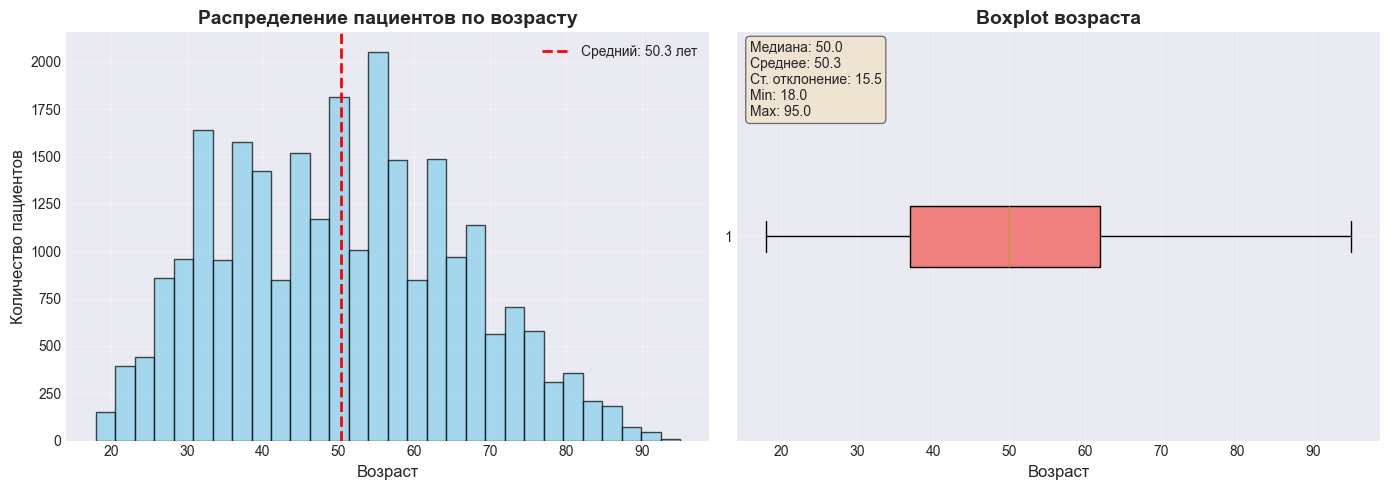

Статистика по возрасту:
count    25770.000000
mean        50.279084
std         15.541798
min         18.000000
25%         37.000000
50%         50.000000
75%         62.000000
max         95.000000
Name: Age, dtype: float64

АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПО ПОЛУ


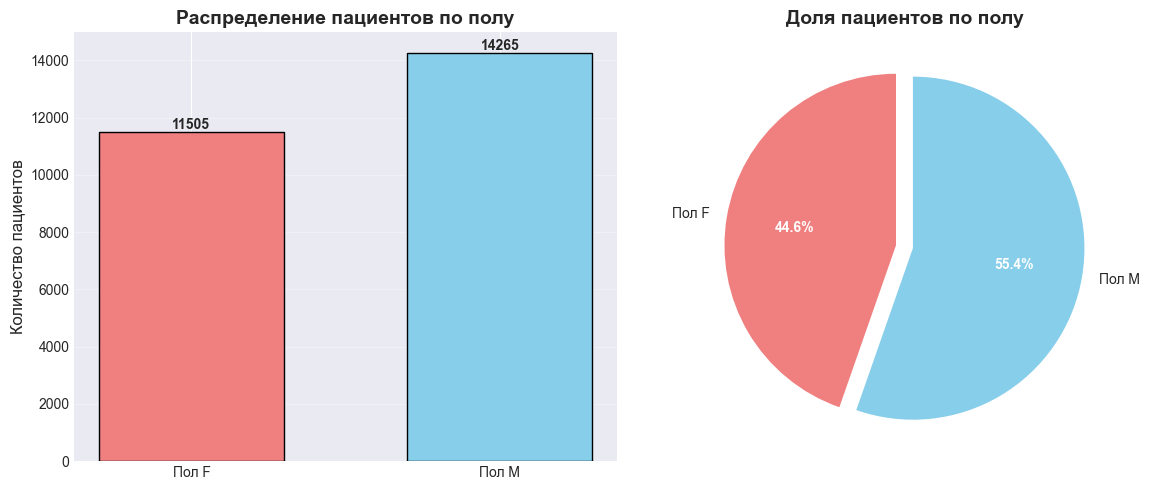

Распределение по полу:
Пол F: 11505 (44.64%)
Пол M: 14265 (55.36%)

АНАЛИЗ ОСНОВНЫХ AHA КОДОВ (ПЕРВЫЙ КОД В ЗАПИСИ)
Всего уникальных основных AHA кодов: 40
Общее количество записей: 25770

ПОЛНЫЙ СПИСОК ОСНОВНЫХ AHA КОДОВ (40 уникальных кодов):
   1. AHA    1:  13905 записей ( 53.96%) | Кумулятивно:  53.96%
   2. AHA   22:   2659 записей ( 10.32%) | Кумулятивно:  64.28%
   3. AHA  147:   1334 записей (  5.18%) | Кумулятивно:  69.45%
   4. AHA   23:   1123 записей (  4.36%) | Кумулятивно:  73.81%
   5. AHA  145:   1045 записей (  4.06%) | Кумулятивно:  77.87%
   6. AHA  105:    917 записей (  3.56%) | Кумулятивно:  81.42%
   7. AHA   60:    786 записей (  3.05%) | Кумулятивно:  84.47%
   8. AHA   21:    723 записей (  2.81%) | Кумулятивно:  87.28%
   9. AHA   50:    663 записей (  2.57%) | Кумулятивно:  89.85%
  10. AHA  146:    540 записей (  2.10%) | Кумулятивно:  91.95%
  11. AHA  106:    473 записей (  1.84%) | Кумулятивно:  93.78%
  12. AHA   30:    384 записей (  1.49%) | Кумуляти

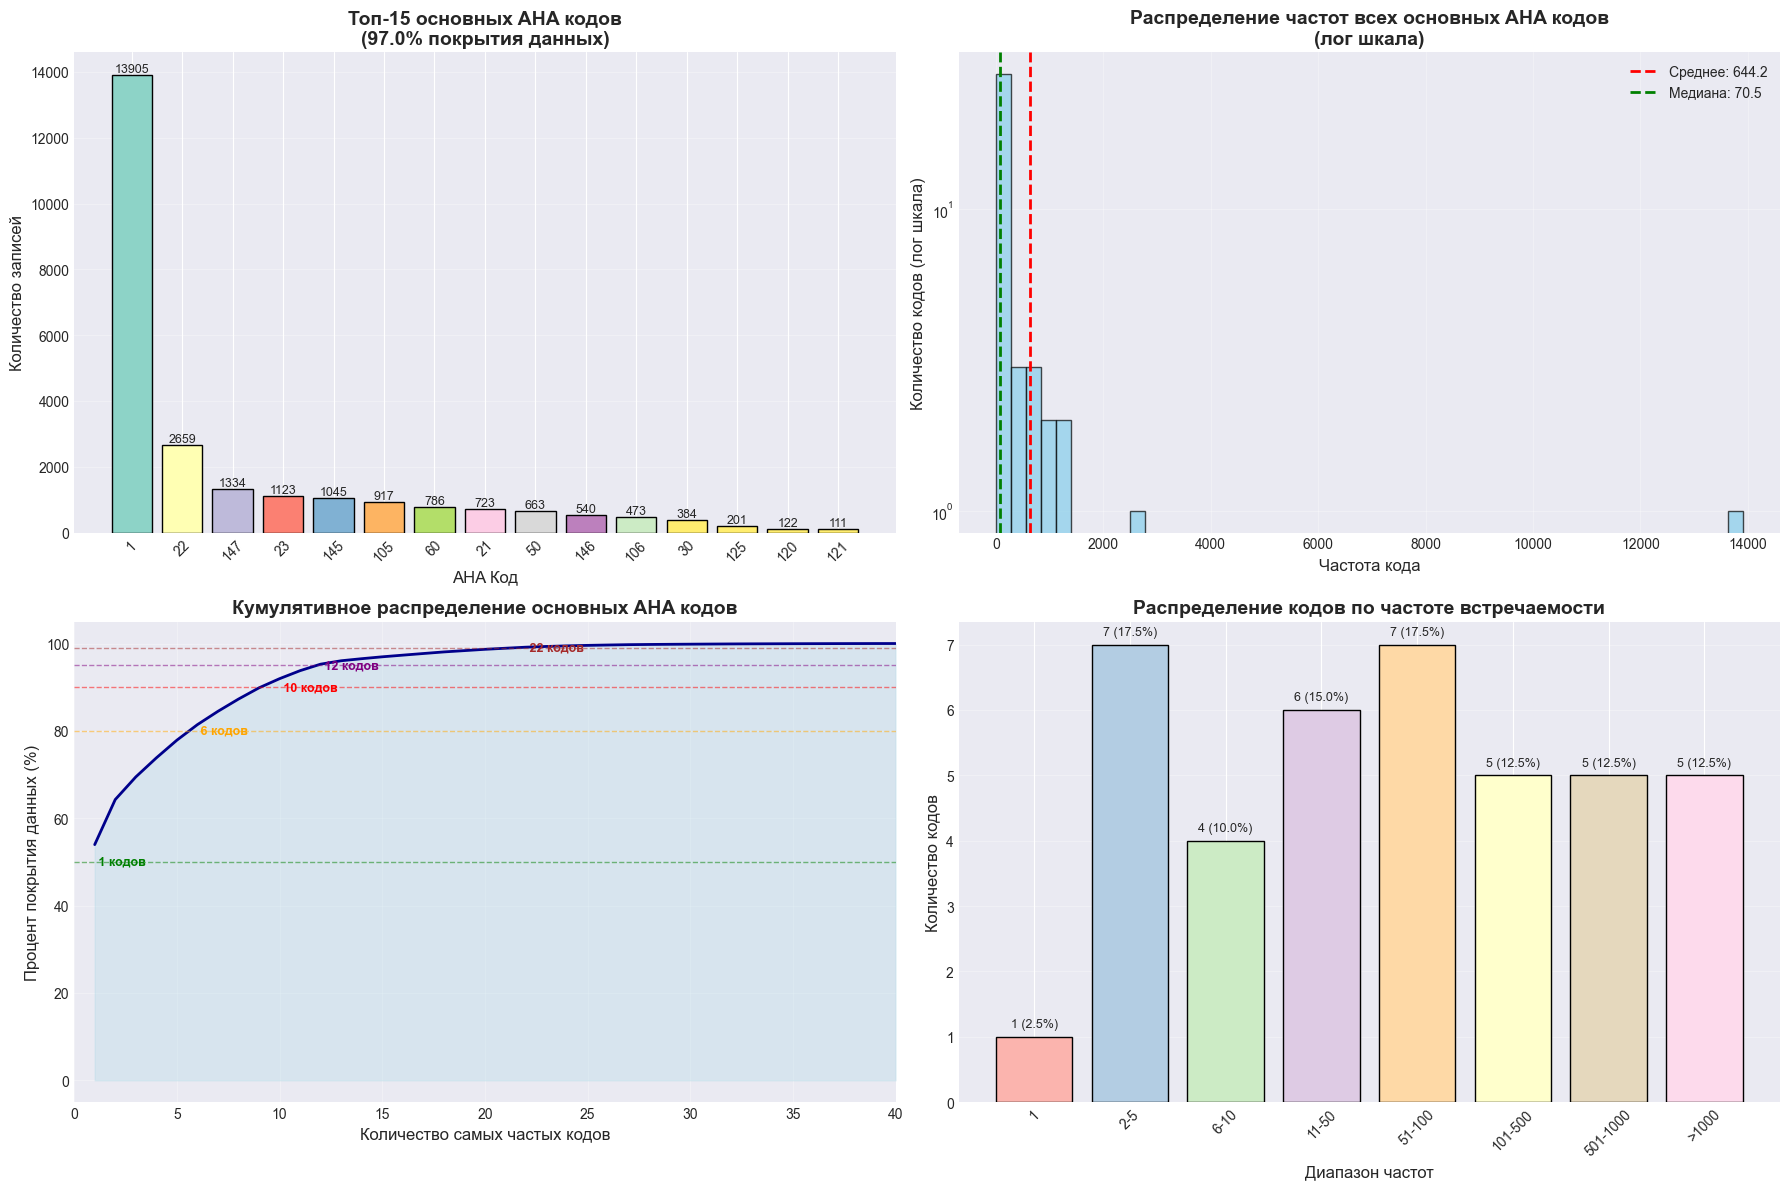


АНАЛИЗ КОДОВ ПОСЛЕ ТОЧКИ С ЗАПЯТОЙ (;)
Записей с точкой с запятой: 3724 (14.5% всех записей)
Всего кодов после точки с запятой: 5576
Уникальных кодов после точки с запятой: 56
Среднее кодов на запись с ';': 1.50


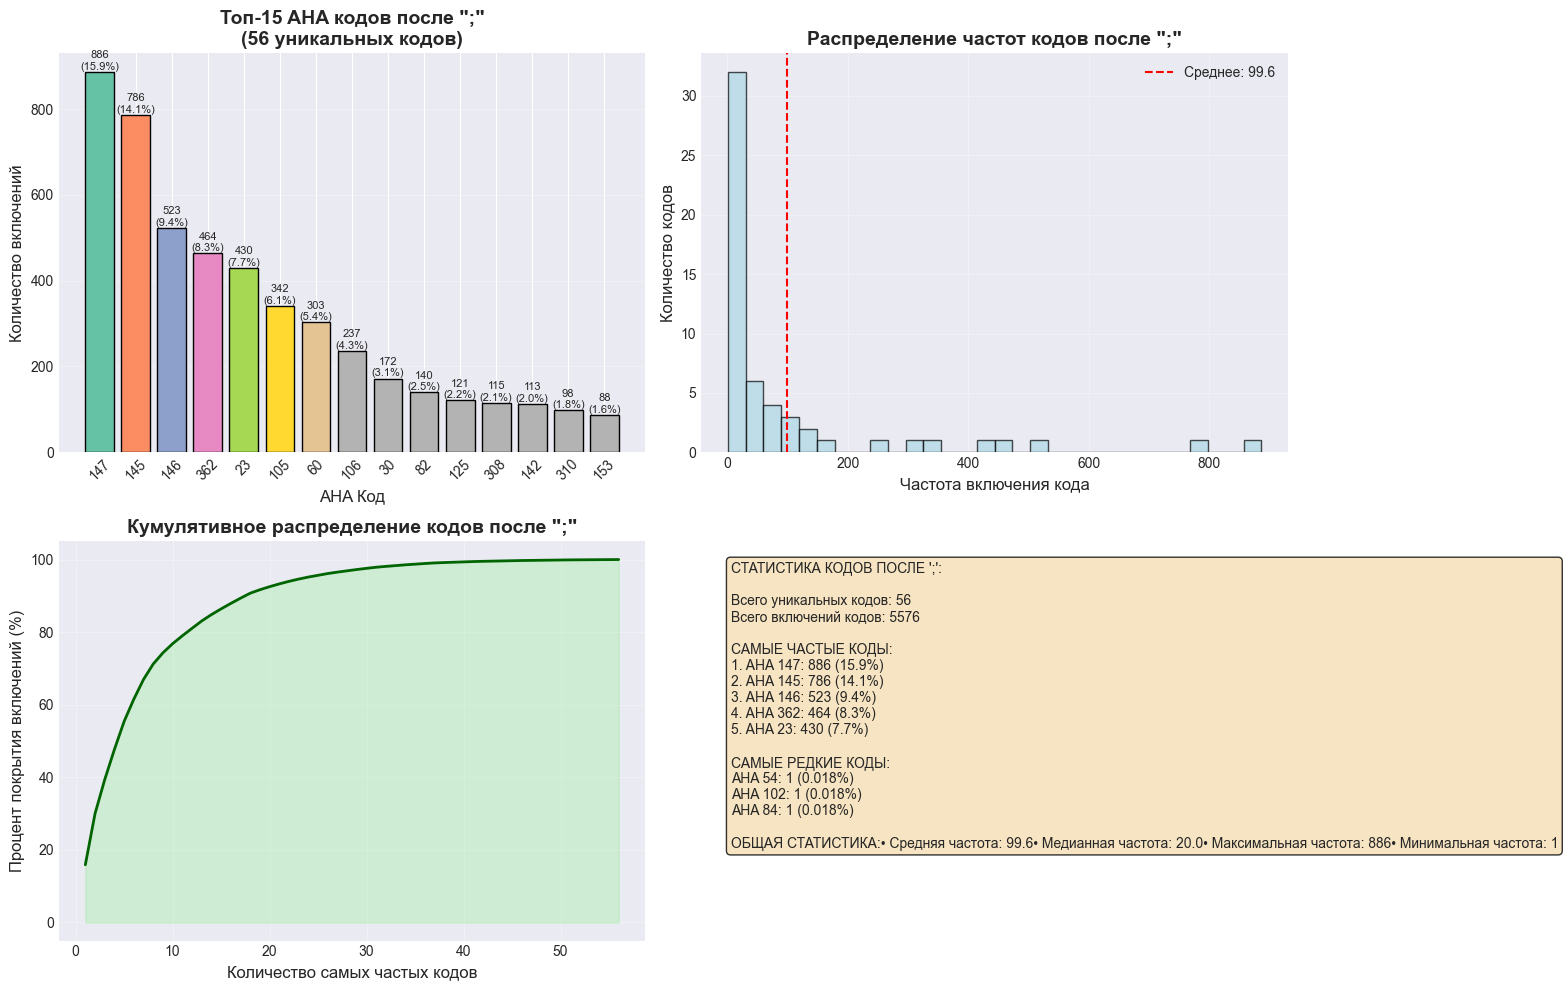


ПОЛНЫЙ СПИСОК КОДОВ ПОСЛЕ ';' (56 уникальных):
  1. AHA  147:   886 включений ( 15.89%) | Кумулятивно:  15.89%
  2. AHA  145:   786 включений ( 14.10%) | Кумулятивно:  29.99%
  3. AHA  146:   523 включений (  9.38%) | Кумулятивно:  39.37%
  4. AHA  362:   464 включений (  8.32%) | Кумулятивно:  47.69%
  5. AHA   23:   430 включений (  7.71%) | Кумулятивно:  55.40%
  6. AHA  105:   342 включений (  6.13%) | Кумулятивно:  61.53%
  7. AHA   60:   303 включений (  5.43%) | Кумулятивно:  66.97%
  8. AHA  106:   237 включений (  4.25%) | Кумулятивно:  71.22%
  9. AHA   30:   172 включений (  3.08%) | Кумулятивно:  74.30%
 10. AHA   82:   140 включений (  2.51%) | Кумулятивно:  76.81%
 11. AHA  125:   121 включений (  2.17%) | Кумулятивно:  78.98%
 12. AHA  308:   115 включений (  2.06%) | Кумулятивно:  81.04%
 13. AHA  142:   113 включений (  2.03%) | Кумулятивно:  83.07%
 14. AHA  310:    98 включений (  1.76%) | Кумулятивно:  84.83%
 15. AHA  153:    88 включений (  1.58%) | Кумулятивно: 

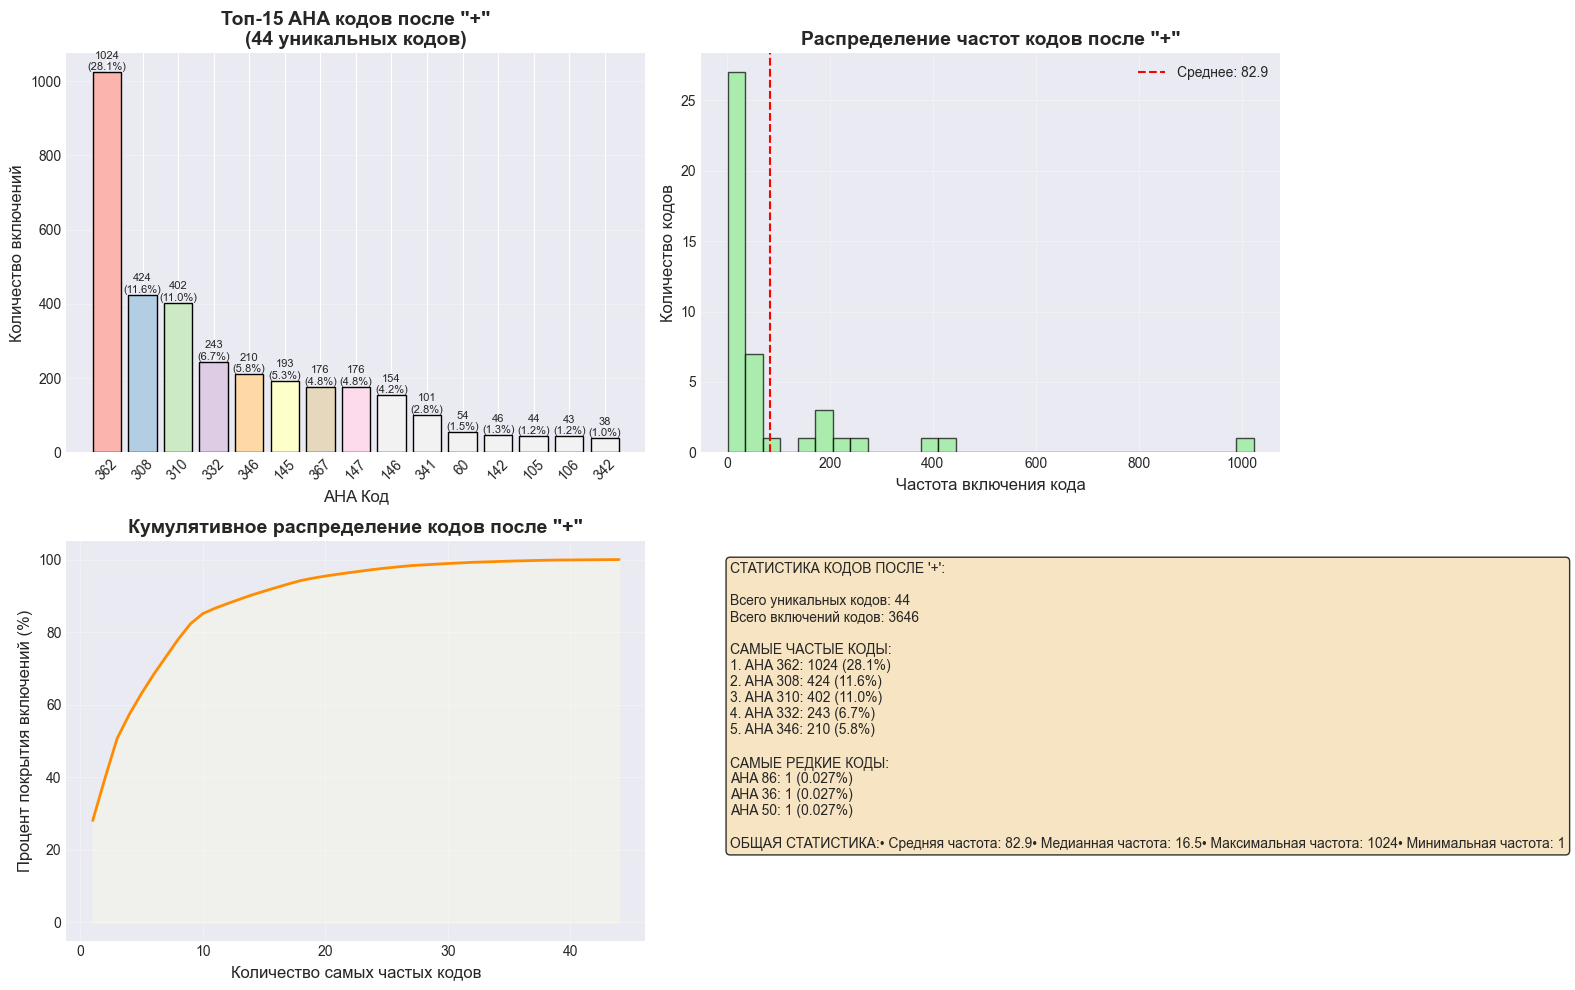


ПОЛНЫЙ СПИСОК КОДОВ ПОСЛЕ '+' (44 уникальных):
  1. AHA  362:  1024 включений ( 28.09%) | Кумулятивно:  28.09%
  2. AHA  308:   424 включений ( 11.63%) | Кумулятивно:  39.71%
  3. AHA  310:   402 включений ( 11.03%) | Кумулятивно:  50.74%
  4. AHA  332:   243 включений (  6.66%) | Кумулятивно:  57.41%
  5. AHA  346:   210 включений (  5.76%) | Кумулятивно:  63.17%
  6. AHA  145:   193 включений (  5.29%) | Кумулятивно:  68.46%
  7. AHA  367:   176 включений (  4.83%) | Кумулятивно:  73.29%
  8. AHA  147:   176 включений (  4.83%) | Кумулятивно:  78.11%
  9. AHA  146:   154 включений (  4.22%) | Кумулятивно:  82.34%
 10. AHA  341:   101 включений (  2.77%) | Кумулятивно:  85.11%
 11. AHA   60:    54 включений (  1.48%) | Кумулятивно:  86.59%
 12. AHA  142:    46 включений (  1.26%) | Кумулятивно:  87.85%
 13. AHA  105:    44 включений (  1.21%) | Кумулятивно:  89.06%
 14. AHA  106:    43 включений (  1.18%) | Кумулятивно:  90.24%
 15. AHA  342:    38 включений (  1.04%) | Кумулятивно: 

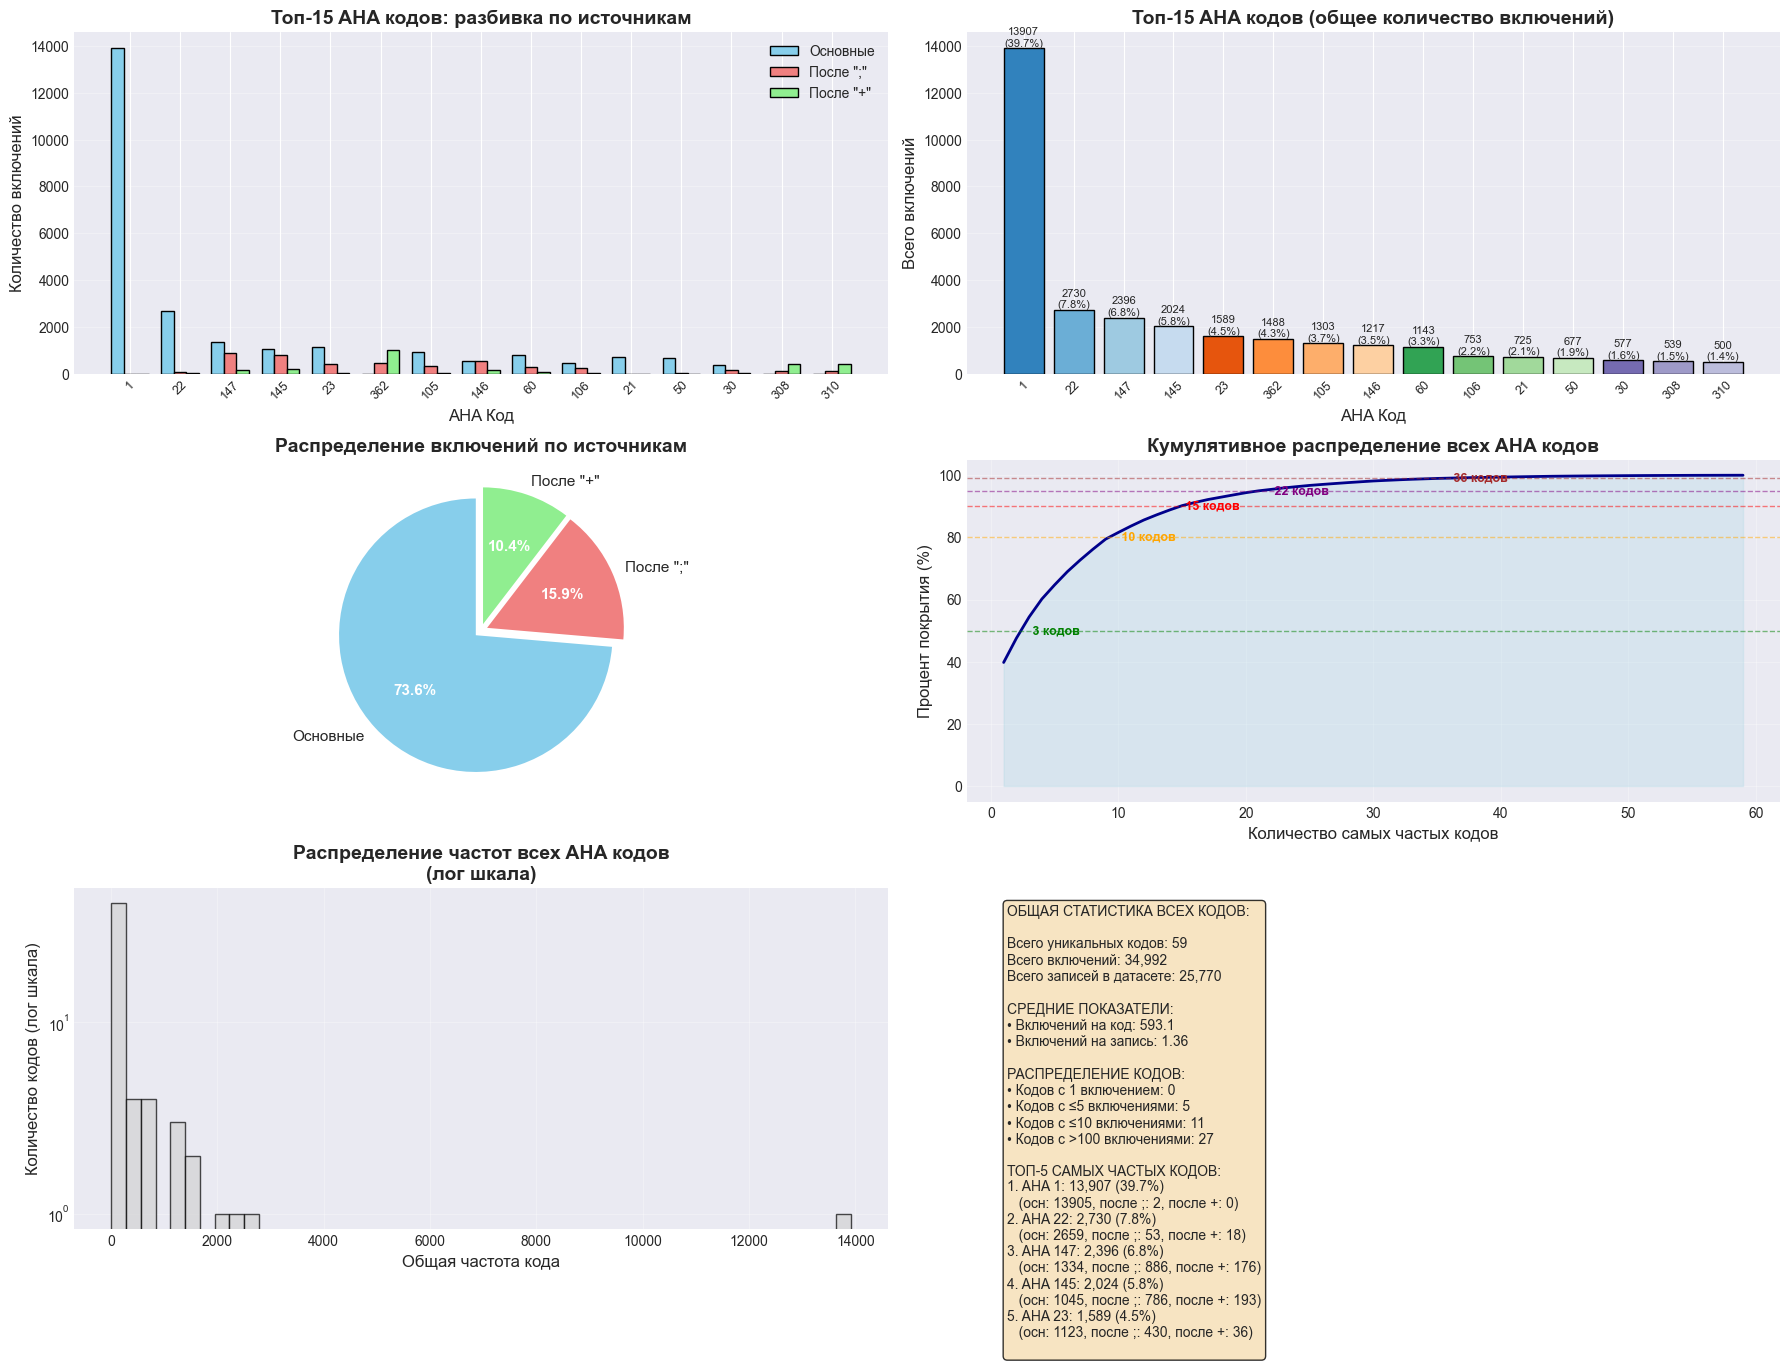

INFO: Successfully validated all paths for china_12_lead dataset



ПОЛНЫЙ СПИСОК ВСЕХ AHA КОДОВ (59 уникальных):
   1. AHA    1:  13907 всего | осн: 13905, после ;:    2, после +:    0 |  39.74% | кум:  39.74%
   2. AHA   22:   2730 всего | осн: 2659, после ;:   53, после +:   18 |   7.80% | кум:  47.55%
   3. AHA  147:   2396 всего | осн: 1334, после ;:  886, после +:  176 |   6.85% | кум:  54.39%
   4. AHA  145:   2024 всего | осн: 1045, после ;:  786, после +:  193 |   5.78% | кум:  60.18%
   5. AHA   23:   1589 всего | осн: 1123, после ;:  430, после +:   36 |   4.54% | кум:  64.72%
   6. AHA  362:   1488 всего | осн:    0, после ;:  464, после +: 1024 |   4.25% | кум:  68.97%
   7. AHA  105:   1303 всего | осн:  917, после ;:  342, после +:   44 |   3.72% | кум:  72.69%
   8. AHA  146:   1217 всего | осн:  540, после ;:  523, после +:  154 |   3.48% | кум:  76.17%
   9. AHA   60:   1143 всего | осн:  786, после ;:  303, после +:   54 |   3.27% | кум:  79.44%
  10. AHA  106:    753 всего | осн:  473, после ;:  237, после +:   43 |   2.15% | кум: 

In [7]:
try:
    print("НАЧАЛО АНАЛИЗА ДАТАСЕТА ECG (china_12_lead)")
    print("=" * 50)

    # Получаем текущую рабочую директорию и определяем проектную директорию
    current_dir = Path.cwd()
    project_dir = current_dir.parent  # Предполагаем, что проект на уровень выше

    # Используем функцию find_csv_dir_files_china для получения путей
    print(f"Поиск файлов датасета в: {project_dir}")
    records_dir, metadata_file, code_file = find_csv_dir_files_china(project_dir)

    print("Найдены следующие файлы:")
    print(f"  • Метаданные: {metadata_file}")
    print(f"  • Коды: {code_file}")
    if records_dir.exists():
        print(f"  • Записи: {records_dir}")

    # Анализ датасета
    df_processed, all_codes_df = analyze_dataset(metadata_file)

except FileNotFoundError as e:
    print(f"❌ Ошибка: {e}")
    print("Убедитесь, что датасет находится в правильной структуре директорий:")
    print("project_dir/data/china_12_lead/metadata.csv")
except Exception as e:
    print(f"❌ Произошла ошибка при анализе данных: {e}")
    traceback.print_exc()